# Model training: Support Vector Machine

We use Support Vector Machine to obtain our prediction model. Our model is svc from sklearn.svm. 

In [1]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Loading the data

In [2]:
path = '/Users/louispht/Documents/git_projects/news_classifier/Data cleaning/Pickles/'

# Dataframe
with open(path + 'df_all.pickle', 'rb') as data:
    df_all = pickle.load(data)

# features_train
with open(path + 'features_train.pickle', 'rb') as data:
    features_train = pickle.load(data)

# y_train
with open(path + 'y_train.pickle', 'rb') as data:
    y_train = pickle.load(data)

# features_test
with open(path + 'features_test.pickle', 'rb') as data:
    features_test = pickle.load(data)

# y_test
with open(path + 'y_test.pickle', 'rb') as data:
    y_test = pickle.load(data)

In [3]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13807 entries, 0 to 13806
Data columns (total 6 columns):
title              13807 non-null object
content            13807 non-null object
link               13807 non-null object
category           13807 non-null object
news_length        13807 non-null int64
cleaned_content    13807 non-null object
dtypes: int64(1), object(5)
memory usage: 647.3+ KB


In [4]:
features_train.shape

(12335, 500)

In [5]:
features_test.shape

(1472, 500)

In [6]:
y_train.shape

(12335,)

In [7]:
y_test.shape

(1472,)

### Randomized Search Cross Validation

In order to get the best model, we use cross validation to select some hyperparameters in the svm model. We use randomized search cross validation over Grid Search Cross validation because it is less time and computation consuming. One could use Grid Search after Randomized search once one has a better idea about the best hyperparamters one is looking for. 

In [8]:
#Hyperparameter options for the svm model
hyper_svc =svm.SVC(random_state=42)

print('Hyperparameters:\n')
print(hyper_svc.get_params())

Hyperparameters:

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


We check the documentation to understand each parameter. 

In [2]:
#help(svm.SVC)

We will tune the following hyperparameters:
'C', 'kernel', 'gamma', 'degree'

In [10]:
# Create the random grid
random_grid = {'C': [.0001, .001, .01, .1, 1.0],
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': [.0001, .001, .01, .1, 1, 10, 100],
              'degree': [1,2,3,4,5],
             }

In [11]:
# First create the base model to tune
svc = svm.SVC(random_state=42)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=42)

# Fit the random search model
random_search.fit(features_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 288.4min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1.0], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'degree': [1, 2, 3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='accuracy', verbose=1)

In [12]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'kernel': 'linear', 'gamma': 0.001, 'degree': 5, 'C': 1.0}

The mean accuracy of a model with these hyperparameters is:
0.812403729226


In [13]:
#Save the best model
best_svc = random_search.best_estimator_

In [14]:
best_svc

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

We fit our model.

In [15]:
best_svc.fit(features_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [16]:
#predictions 
svc_pred = best_svc.predict(features_test)

### Performance Analysis

We use confusion matrix, the classification report and accuracy to analyse the performance.

In [18]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(y_train, best_svc.predict(features_train)))

The training accuracy is: 
0.865910012161


In [19]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(y_test, svc_pred))

The test accuracy is: 
0.81589673913


We see that there is potentially some overfitting. We could reduce the amount of features we have. This can also be explained by the fact that our test data were obtained for a specific day in time. So temporal changes could cause covariate shift. 

In [30]:
# Classification report
categories = {'actualite':0, 'sports':4, 'international':3, 'affaires':1, 'culture':2}
print("Classification report")
print(classification_report(y_test,svc_pred, target_names=categories))

Classification report
               precision    recall  f1-score   support

    actualite       0.67      0.84      0.74       342
       sports       0.79      0.78      0.78       243
international       0.89      0.74      0.81       274
     affaires       0.81      0.85      0.83       220
      culture       0.97      0.85      0.91       393

  avg / total       0.83      0.82      0.82      1472



#### Confusion matrix

We first get our dataframe with the labels. 

In [23]:
# df_all_le
with open(path + 'df_all_le.pickle', 'rb') as data:
    df_all_le = pickle.load(data)

In [24]:
df_all_le.head(2)

,title,content,link,category,news_length,cleaned_content,label_enc
0,"Oui, Marie-Josée Lord est une chanteuse d'opéra!",«Je ne suis pas une chanteuse d'opéra.» Marie-...,https://www.lapresse.ca/arts/festivals/montrea...,culture,3137,chanteux oper mariejos lord laiss tomb c...,2
1,Une vallée sans foi ni loi,C'était une paisible vallée agricole où les po...,https://www.lapresse.ca/international/amerique...,international,7051,paisibl vall agricol où polici regl chican...,3


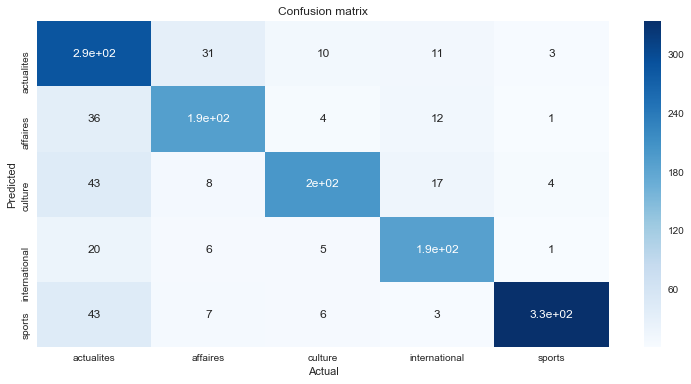

In [25]:
#Confusion matrix
aux_df = df_all_le[['category', 'label_enc']].drop_duplicates().sort_values('category')
conf_matrix = confusion_matrix(y_test, svc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['category'].values, 
            yticklabels=aux_df['category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

As expected, we see that our model has some difficulties with the 'actualites' category. This is partially due to the fact that this category is a bit more vague in terms of its content. 

#### Saving the model

In [26]:
d = {
     'Model': 'SVM',
     'Training Set Accuracy': accuracy_score(y_train, best_svc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(y_test, svc_pred)
}

df_models_svc = pd.DataFrame(d, index=[0])

In [27]:
df_models_svc

,Model,Training Set Accuracy,Test Set Accuracy
0,SVM,0.86591,0.815897


In [28]:
with open('Models/best_svc.pickle', 'wb') as output:
    pickle.dump(best_svc, output)
    
with open('Models/df_models_svc.pickle', 'wb') as output:
    pickle.dump(df_models_svc, output)

#### Looking at some fail classification

In [32]:
# df_test
with open(path + 'df_test.pickle', 'rb') as data:
    df_test = pickle.load(data)

In [35]:
df_test

,title,content,link,category,news_length,cleaned_content
0,Destruction de l'Amazonie: Ottawa appelé à aba...,(Ottawa) Le gouvernement fédéral a été interpe...,https://www.lapresse.ca/actualites/national/20...,actualites,3734,ottaw gouvern fédéral interpel suspendr n...
1,Explosion à Beyrouth: Ottawa facilitera la ven...,(Ottawa) Un mois après la tragédie de Beyrouth...,https://www.lapresse.ca/actualites/national/20...,actualites,1820,ottaw mois apres traged beyrouth canad ann...
2,"L'enfance au Canada est en crise, selon deux r...",(Montréal) Un rapport publié mercredi par l’UN...,https://www.lapresse.ca/actualites/national/20...,actualites,2659,montréal rapport publi mercred unicef affirm...
3,La création des pensionnats autochtones reconn...,Ils ont détruit la vie des Autochtones pendant...,https://www.lapresse.ca/actualites/national/20...,actualites,3005,détruit vi autochton pend plus siecl main...
4,L'affluence dans les transports en commun en c...,(Ottawa) De nouvelles statistiques montrent qu...,https://www.lapresse.ca/actualites/national/20...,actualites,1161,ottaw nouvel statist montrent system trans...
...,...,...,...,...,...,...
1467,Drôles de souvenirs à «Cuvée comique»,MONTRÉAL – Philippe Laprise reçoit des humoris...,https://www.journaldemontreal.com/2020/08/03/d...,culture,3191,montréal – philipp lapris reçoit humor compli...
1468,Dieudonné banni de Facebook et Instagram,PARIS | Le groupe Facebook a annoncé lundi avo...,https://www.journaldemontreal.com/2020/08/03/h...,culture,2256,paris | group facebook annonc lund avoir ban...
1469,Les blagues de Mike Ward en Cour suprême,La Cour suprême du Canada accepte de juger si ...,https://www.journaldemontreal.com/2020/07/30/m...,culture,2588,cour suprêm canad accept jug si blagu crue...
1470,Jérémy Gabriel accepte la décision,Jérémy Gabriel aurait préféré que la demande d...,https://www.journaldemontreal.com/2020/07/30/m...,culture,1035,jérémy gabriel préfer demand appel mik war...


In [56]:
from IPython.display import display
id_to_category = dict(aux_df[['label_enc', 'category']].values)
for predicted in aux_df.label_enc:
    for actual in aux_df.label_enc:
        if predicted != actual and conf_matrix[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_matrix[actual, predicted]))
            display(df_test.loc[(y_test == actual) & (svc_pred == predicted)][['title', 'category', 'content']].sample(10))
            print('')

'affaires' predicted as 'actualites' : 36 examples.


,title,category,content
1067,Manque de main-d’œuvre: des mesures insuffisa...,affaires,Alors que plusieurs entreprises doivent toujou...
1105,Lion envisage de se lancer en Bourse,affaires,La Compagnie Électrique Lion de Saint-Jérôme n...
388,De l’aluminium garanti sans COVID-19 et fait a...,affaires,(Montréal) Tourner une poignée de porte sans s...
427,350 000$ pour la COVID-19,affaires,Alors que la crise sanitaire a exacerbé les be...
375,Une assurance vie pour femmes enceintes,affaires,Les femmes enceintes peuvent maintenant souscr...
1058,Faut-il craindre une hausse de saisies de mai...,affaires,On aura beau dire ce qu’on veut contre les ban...
414,Le virage «sécurité» de la mine Raglan,affaires,"Au 62e parallèle Nord, là où plus aucun arbre ..."
295,Trudeau admet qu'il y a des retards dans la li...,affaires,(Ottawa) Justin Trudeau a admis jeudi qu’il y ...
418,145 000$ pour les enfants handicapés,affaires,"Le 14 août dernier, par zoom et en direct du F..."
1059,Des dépenses toujours importantes,affaires,La rentrée scolaire est synonyme de dépenses i...



'culture' predicted as 'actualites' : 43 examples.


,title,category,content
707,Love Me Tender v.1 : entre l’ombre et la lumière,culture,"Se laissant porter par son envie de créer, la ..."
700,Musée Pointe-à-Callière: Francine Lelièvre pré...,culture,La fondatrice et directrice générale du musée ...
1441,Imagine Van Gogh arrive à Québec le 18 juillet,culture,"Avec un retard de trois semaines, causé par le..."
1402,Objectif: 1000 spectateurs en salle cet automne,culture,Le patron de Québecor Groupe Sports et diverti...
1404,La danse investit quatorze quartiers,culture,Ils sont dix-sept et ils offrent des performan...
1447,La Ronde: pas de remboursement pour les clients,culture,MONTRÉAL | Les détenteurs d’un passeport-saiso...
723,Arnaud Soly quitte les réseaux sociaux,culture,"L’humoriste Arnaud Soly, principalement connu ..."
1471,L'ex de Julien Lacroix publie un long témoign...,culture,L’ancienne amoureuse de Julien Lacroix Geneviè...
1444,MAC: retour au musée en temps de pandémie,culture,Le Musée d'art contemporain de Montréal (MAC) ...
1415,«Un pas dans la bonne direction»,culture,Les organisateurs de festivals se réjouissent ...



'international' predicted as 'actualites' : 20 examples.


,title,category,content
1044,Les manchots menacés par le ravitaillement en...,international,"PORT ELIZABETH | Dans le vacarme des moteurs, ..."
973,Le plus vieux couple marié au monde,international,"Julio Cesar Mora et sa femme, Waldramina Maclo..."
205,Argentine: un vaccin chinois contre la COVID-1...,international,(Buenos Aires) Un projet de vaccin contre la C...
984,Le virus ferme les pubs et assèche la campagne,international,"Dans les pubs de Dunmore, les verres de Guinne..."
1043,"La musaraigne-éléphant, une espèce pas si per...",international,"Depuis un demi-siècle, beaucoup croyaient la m..."
262,«Gilets jaunes»: trois procès à venir pour le ...,international,"(Paris) Après l’immense émoi, des procès a min..."
1006,Une fillette s’envole avec un cerf-volant,international,Une fillette de 3 ans a sans aucun doute eu la...
1041,Le système éducatif paient le prix fort,international,"NAIROBI | «Je ne me sens pas bien, car le ""cor..."
264,Procès Charlie: le principal accusé s’en prend...,international,(Paris) Il jette un regard noir sur la salle p...
978,Les propriétaires français s'organisent,international,Effrayés par la série de mutilations de chevau...



'sports' predicted as 'actualites' : 43 examples.


,title,category,content
1229,À la découverte du réseau des zecs,sports,Plusieurs points militent en faveur des zecs d...
1242,Estephan pourrait devoir patienter,sports,Le médecin de la Santé publique Richard Massé...
580,Alcool au volant et cocaïne : le Norvégien Pet...,sports,(Oslo) Le double champion olympique de ski de ...
1219,Colin Kaepernick au Temple de la renommée?,sports,Après avoir découvert que tous pouvaient soume...
1230,Une fin de semaine consacrée à la relève,sports,La toute première fin de semaine de chasse des...
574,GYM blanchi de trois accusations sur quatre : ...,sports,(Montréal) Le permis annuel du Groupe Yvon Mic...
1226,Pour faire flèche de tout bois à tout coup,sports,Pour l’amateur qui veut pratiquer la chasse au...
1234,Nouvelle saison de chasse du chevreuil,sports,"Depuis le temps qu’elle était attendue, la fin..."
1175,Une saison record pour le tennis à Québec,sports,Les données de l’Association régionale de tenn...
1220,Bernaches: ce qu’il faut savoir,sports,"Dès demain, il sera possible de se lancer aux ..."



'actualites' predicted as 'affaires' : 31 examples.


,title,category,content
787,Des slogans à une vraie stratégie économique,actualites,François Legault adore les slogans. On l’a vu ...
845,La première boisson à base de cannabis en vente,actualites,"SMITHS FALLS, Ontario – La première boisson in..."
837,Pas encore de politique sur la fixation des p...,actualites,Contrairement à la Société des alcools du Québ...
899,260 000 $ d’amendes pour une compagnie,actualites,Une société de portefeuille montréalaise a été...
50,Dix employés de BRP infectés par la COVID-19 à...,actualites,Dix travailleurs de l’usine BRP de Valcourt on...
811,Les chaussées préservées en raison de la COVI...,actualites,Même si certains camions ont pu transporter de...
842,La SQDC 26 M$ en dividendes au gouvernement,actualites,"À son deuxième exercice financier, la Société ..."
923,La maison de vos rêves grâce à la pandémie?,actualites,Du «jamais-vu» depuis 40 ans. Voilà comment es...
125,Crouler sous les emballages,actualites,Les boîtes de prêt-à-cuisiner livrées à domici...
838,Second Cup se lance dans le cannabis,actualites,TORONTO | Second Cup a ouvert sa première bout...



'actualites' predicted as 'culture' : 10 examples.


,title,category,content
141,Des jumeaux écoutent In the Air Tonight et leu...,actualites,Des jumeaux qui écoutaient pour la première fo...
165,Un trou noir hors normes découvert par les ond...,actualites,(Paris) Il a mis 7 milliards d’années-lumière ...
896,Laval veut protéger 14 % de son territoire,actualites,Laval ambitionne de protéger 14 % de son terri...
889,"Intello et timide, écrasée par les responsabi...",actualites,"Venise | Derrière l’égérie du climat, une ado ..."
928,Dernier long week-end de l’été,actualites,"Il fut un temps où, lors de la fin de semaine ..."
914,Véro contre les coquerelles,actualites,Je ne sais pas ce qui me choque le plus dans c...
136,Le dernier magasin Blockbuster se loue pour de...,actualites,(Los Angeles) Le dernier magasin Blockbuster d...
134,Un «sorcier» de la Nouvelle-Zélande se souvien...,actualites,Bien avant de devenir le Sorcier de la Nouvell...
32,Sondage CROP-La Presse: «nous allons nous ajus...,actualites,La mairesse Valérie Plante a indiqué « prendre...
861,Les tigres de papier,actualites,Richard Martineau notait qu’une partie de notr...



'actualites' predicted as 'international' : 11 examples.


,title,category,content
142,La Pat'Patrouille retirée des ondes? Pas si vite,actualites,Il faut vérifier ses sources... avant de dire ...
137,Deux bélugas de Chine arrivent dans leur sanct...,actualites,(Reykjavik) Deux bélugas provenant d’un aquari...
169,La mort de Chadwick Boseman illustre le fléau ...,actualites,(Washington) La mort de l'acteur américain Cha...
133,Un Australien frappe un requin à coups de poin...,actualites,(Sydney) Un Australien est devenu un « héros »...
900,Légère baisse des incendies en Amazonie en août,actualites,Le nombre d’incendies en Amazonie brésilienne ...
128,Un vol à plus de 7000 mètres d'altitude accroc...,actualites,Le magicien américain David Blaine a effectué ...
139,Elle tombe dans une bouche d'égout après un ac...,actualites,Une femme a joué de malchance alors qu’elle ro...
790,Berlin critique l’appel de Trump à voter deux...,actualites,Le chef de la diplomatie allemande a accusé di...
135,Un restaurant chinois s’excuse d’avoir pesé se...,actualites,"(Pékin) Un restaurant de Changsha, dans le cen..."
28,Ottawa maintient la pression sur le régime Lou...,actualites,(Ottawa) Le Canada laisse entendre qu’il est p...



'affaires' predicted as 'international' : 12 examples.


,title,category,content
298,"Décès de David Graeber, figure de proue d’Occu...",affaires,(New York) L’anthropologue américain David Gra...
344,Facebook et Twitter démantèlent une petite cam...,affaires,(San Francisco) Facebook et Twitter ont de nou...
310,Le pétrole se replie après le passage sans dég...,affaires,(New York) Les cours du pétrole ont terminé en...
341,Verizon investit près de 2 milliards supplémen...,affaires,"(San Francisco) Verizon va dépenser près de 1,..."
347,TikTok se conformera à la nouvelle réglementat...,affaires,"(Pékin) Le groupe chinois ByteDance, propriéta..."
311,Les fonds gérés par des femmes rapportent plus...,affaires,(New York) Les fonds communs de placement géré...
343,Donald Trump ne lâche rien sur la vente de TikTok,affaires,(San Francisco) Donald Trump a réitéré mardi s...
338,Chine: Apple clarifie sa politique sur la libe...,affaires,(Paris) Accusé par des ONG et investisseurs d’...
293,La pandémie pourrait donner le « baiser de la ...,affaires,(Genève) La pandémie de coronavirus a accru la...
337,Facebook retire les comptes du groupe américai...,affaires,(San Francisco) Facebook a retiré les comptes ...



'culture' predicted as 'international' : 17 examples.


,title,category,content
1357,Harry et Meghan dans leur nouvelle maison,culture,"LOS ANGELES | Le prince Harry et son épouse, M..."
741,Britney Spears ne veut plus être sous tutelle ...,culture,(Los Angeles) La vedette américaine de la pop ...
744,Joe Biden appelle Cardi B à faire voter les je...,culture,(New York) Preuve que le vote des jeunes est e...
769,Robert Pattinson positif à la COVID-19 ? Le to...,culture,"(Los Angeles) Le tournage de The Batman, derni..."
737,Kanye West sur le bulletin de vote du Tennessee,culture,(Montréal) Le rappeur et producteur Kanye West...
724,Dieudonné interdit de Facebook et Instagram,culture,(Paris) Ses saillies antisémites ne trouveront...
733,Le monde selon Adib,culture,(Paris) La chaîne YouTube du polémiste françai...
692,Banksy au secours des migrants,culture,(Rome) C’est un nouveau coup d’éclat : dans le...
732,La chaîne YouTube de Dieudonné supprimée,culture,(Paris) La chaîne YouTube du polémiste françai...
684,Propos sur les personnes transgenres: J. K. Ro...,culture,(Londres) L’écrivaine britannique J. K. Rowlin...


Looking at the examples, we really see that 'actualites' is a not so well defined category, causing some classifications problems. A lot of the other misclassification can be understood, for eample some 'affaires' articles talk about Trump or China, so could easilly be classified in 'international'.